Enter the folder name: conventional method-number of crystals by time
Working...
Creating 12 fps video from images in conventional method-number of crystals by time\processed...
Completed


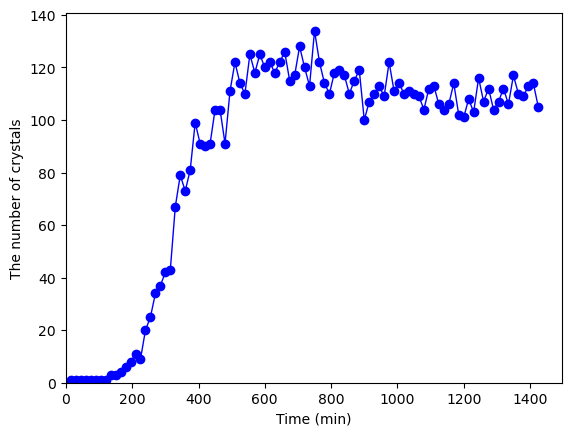

In [1]:
import cv2
import os
import glob
import numpy as np
import openpyxl
from matplotlib import pyplot as plt

img_path = input('Enter the folder name: ')

interval = 15  # Please change here to set the interval time (min)
frames_per_seconds = int(12)  # for video

# Which area do you crop
point = [95,945]  # y, x
length_x = 415
length_y = 415

raw_path = os.path.join(img_path, 'raw-images')
ID_ = os.path.splitext(os.path.basename(img_path))[0]

if not os.path.exists(raw_path):
    os.makedirs(raw_path)

f_list = glob.glob(os.path.join(img_path, '*.jpg'))
f_list.sort()

v_list = glob.glob(os.path.join(img_path, '*.mov'))

if v_list:  # Check if v_list is not empty
    os.rename(v_list[0], os.path.join(img_path, 'video1.MOV'))

i = 0
for file in f_list:
    os.rename(file, os.path.join(raw_path, '{0:04d}'.format(i) + 'min.JPG'))
    i += interval

pro_path = os.path.join(img_path, "processed")

# Processing multiple images
flist = glob.glob(os.path.join(raw_path, '*.jpg'))
flist.sort()

if not os.path.exists(pro_path):
    os.makedirs(pro_path)

# MAKE EXCEL FILE
wb = openpyxl.Workbook()
ws = wb.create_sheet('Data', 0)

ws.cell(2, 2, 'Time (min)')
ws.cell(2, 3, 'Crystal Number')
ws.cell(2, 4, 'Black area')
ws.cell(2, 5, 'Area list')

print('Working...')

x = []  # time
y = []  # number of crystals

j = 0
for file in flist:
    ID = os.path.splitext(os.path.basename(file))[0]
    img = cv2.imread(file)
    if img is None:
        print(f"Error: Could not read image {file}. Skipping...")
        continue  # Skip processing if image cannot be read

    img1 = img[point[0]:point[0] + length_y, point[1]:point[1] + length_x]  # Corrected cropping dimensions
    time = j * interval
    x.append(time)
    ws.cell(3 + j, 2, time)
    lower = np.array([0, 0, 0])
    upper = np.array([100, 100, 100])  # set threshold
    if img1.size == 0:
        print(f"Error: Cropped image from {file} is empty. Skipping...")
        continue  # Skip processing if cropped image is empty
    frame_mask = cv2.inRange(img1, lower, upper)
    cons, hierarchy = cv2.findContours(frame_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(img1, cons, -1, (0, 255, 0), 1)
    ws.cell(3 + j, 3, len(cons))
    y.append(len(cons))
    area_list = []
    for k in range(len(cons)):
        area = cv2.contourArea(cons[k])  # / scale
        area_list.append(area)
        ws.cell(3 + j, 5 + k, area)
    output_path = os.path.join(pro_path, ID + '.jpg')
    cv2.imwrite(output_path, img2)

    j += 1

wb.save(os.path.join(img_path, ID_ + ' data.xlsx'))

fig_dir = os.path.join(img_path, ID_ + ' figure.jpg')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(left=0, right=max(x) * 1.05)
ax.set_ylim(bottom=0, top=max(y) * 1.05)
ax.set_xlabel('Time (min)')
ax.set_ylabel('The number of crystals')
ax.plot(x, y, "-", c="#0000ff", linewidth=1, marker='o')
fig.savefig(fig_dir)

# Video
save_path = os.path.join(img_path, "video2.mp4")

print('Creating ' + str(frames_per_seconds) + ' fps video from images in ' + str(pro_path) + '...')

# Make video
flist = glob.glob(os.path.join(pro_path, '*.jpg'))
flist = sorted(flist, key=os.path.getmtime)

im = cv2.imread(flist[0])
if im is None:
    print("Error: Could not read the first image.")
    exit(1)

hh = im.shape[0]
ww = im.shape[1]

size = (hh, ww)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
save = cv2.VideoWriter(save_path, fourcc, frames_per_seconds, size)

for file in flist:
    # Read the image
    im1 = cv2.imread(file)
    if im1 is None:
        print(f"Error: Could not read video frame {file}. Skipping...")
        continue  # Skip writing frame if it cannot be read
    save.write(im1)

# When everything done, release the capture
save.release()
cv2.destroyAllWindows()
print('Completed')
